# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

\begin{align*}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2)
\end{align*}

with 11 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

torch.set_default_dtype(torch.float64)
%set_env CUDA_VISIBLE_DEVICES=1

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=1


In [64]:
import pandas as pd

df = pd.read_csv('crypto-markets.csv')

In [65]:
currencies = ["BTC", "ETH", "LTC"]
df_cur = df.loc[df["symbol"].isin(currencies)][["symbol", "date", "close"]]

In [66]:
from datetime import datetime
earliest_date = datetime.strptime(df_cur.date[0], '%Y-%m-%d')
df_cur["days"] = df_cur["date"].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d') - earliest_date).days)

In [118]:
X_list = []
y_list = []
df_cur_truncated = df_cur.loc[df_cur["days"] > 830]
for symbol in df_cur_truncated["symbol"].unique():
    # Get df for just this current symbol
    df_symb = df_cur_truncated.loc[df_cur_truncated["symbol"] == symbol]
    
    # extract X values
    X_list.append(df_symb["days"].values)
    # extract y values
    y_list.append(df_symb["close"].values)


In [119]:
X = torch.stack([torch.from_numpy(zz) for zz in X_list]).unsqueeze(-1)
y = torch.stack([torch.from_numpy(zz) for zz in y_list])

X = (X - 830.) / 365.
y = (y - y.mean(dim=-1, keepdim=True)) / (y.std(dim=-1, keepdim=True))

train_x = X[:, :-120, :]
train_y = y[:, :-120]
test_x = X[:, -120:, :]
test_y = y[:, -120:]

train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

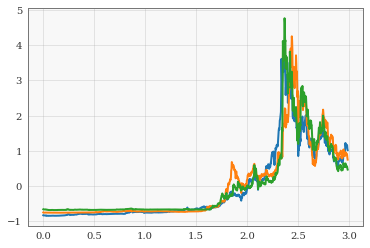

In [120]:
plt.plot(train_x.cpu().squeeze(-1).t(), train_y.cpu().t())

In [97]:
from botorch.fit import fit_gpytorch_model
from gpytorch.kernels import ScaleKernel
from gpytorch.kernels.spectral_autoregressive_flow_kernel import RFNSSpectralNFKernel, RFNSSpectralDeltaKernel
from gpytorch.mlls import ExactMarginalLogLikelihood

In [98]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.LinearMean(1)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = RFNSSpectralDeltaKernel(
            num_dims=train_x.size(-1),
            num_deltas=2048,
            batch_size=train_x.size(-3),
#             nonstationary=True
        )
        base_covar_module.initialize_from_data(train_x[1], train_y[1])
#         smk = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=1)
#         smk.mixture_scales = 30
#         smk.mixture_weights = 0.01
        
        self.covar_module = ScaleKernel(base_covar_module, batch_size=train_x.size(-3))
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-10)).cuda()
# likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
# likelihood.noise = 1e-1
# likelihood.noise_covar.raw_noise.requires_grad_(False)
model = ExactGPModel(train_x, train_y, likelihood).cuda()

In [99]:
import pyro

pyro.clear_param_store()

model.train()
likelihood.train()
mll = ExactMarginalLogLikelihood(model.likelihood, model)

# optimizer = torch.optim.Adam([
#     {'params': gp_params, 'lr': 0.01},
#     {'params': dsf_params, 'lr': 0.01, 'weight_decay': 1e-2}]
# )

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[200])
with gpytorch.settings.max_cholesky_size(5000), gpytorch.settings.num_spectral_samples(2000):
    for i in range(1000):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y).mean()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Iteration {i} - loss = {loss:.2f} - noise = {likelihood.noise.item():e}')
        
        scheduler.step()

Iteration 0 - loss = 1.06 - noise = 6.443967e-01
Iteration 10 - loss = 0.61 - noise = 2.849289e-01
Iteration 20 - loss = 0.12 - noise = 1.098889e-01
Iteration 30 - loss = -0.32 - noise = 3.895048e-02
Iteration 40 - loss = -0.56 - noise = 1.470077e-02
Iteration 50 - loss = -0.54 - noise = 8.532510e-03
Iteration 60 - loss = -0.56 - noise = 9.412759e-03
Iteration 70 - loss = -0.56 - noise = 1.189124e-02


KeyboardInterrupt: 

In [92]:

with gpytorch.settings.max_cholesky_size(5000), gpytorch.settings.num_spectral_samples(10000):
    fit_gpytorch_model(mll, options={'options': {'maxiter': 5}})

KeyboardInterrupt: 

## Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a `MultivariateNormal` containing the prior mean and covariance from forward, a trained GP model in eval mode returns a `MultivariateNormal` containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```

The `gpytorch.settings.fast_pred_var` context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using [LOVE](https://arxiv.org/abs/1803.06058).

In [100]:
model.train()

with gpytorch.settings.max_cholesky_size(5000), gpytorch.settings.fast_computations(False):
    output = model(train_x)
    loss = -mll(output, train_y)
    print(f'{loss.mean():.3f}')

-0.535


In [112]:
test_x = test_x[:, :20, :]
test_y = test_y[:, :20]

In [121]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.max_cholesky_size(5000), gpytorch.settings.num_spectral_samples(5000):
    test_x_f = torch.cat([train_x, test_x], dim=-2)
    observed_pred = model.likelihood(model(test_x_f))

## Plot the model fit


In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

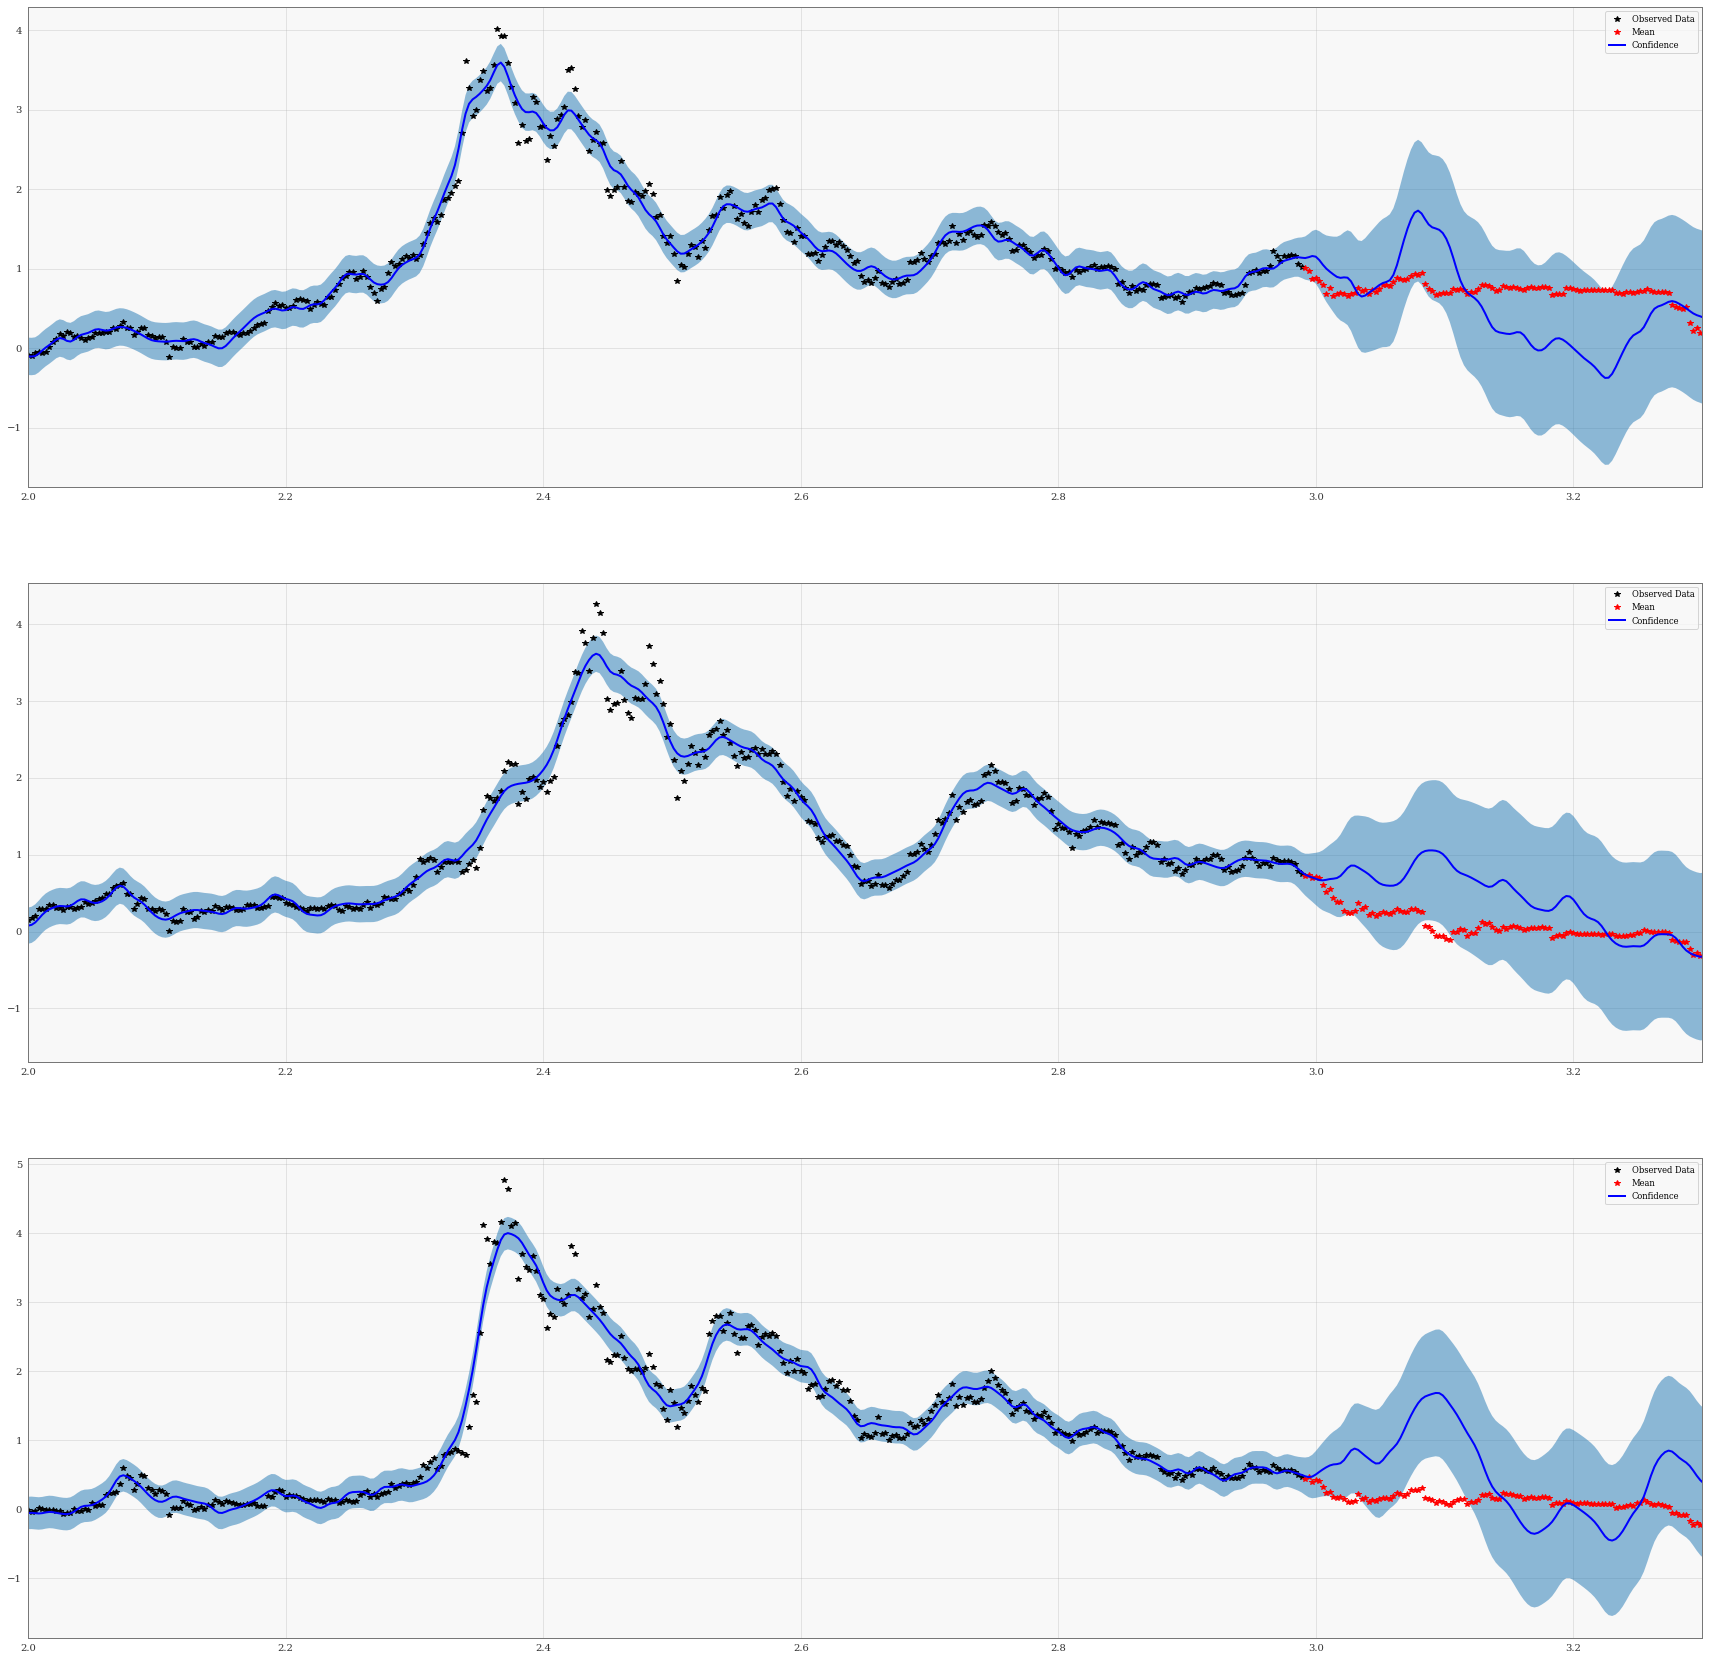

In [122]:
_task = 3

plt.figure(figsize=(30, 30))
for _task in range(3):
    ax = plt.subplot(3, 1, _task + 1)

    with torch.no_grad():
        # Initialize plot
#         f, ax = plt.subplots(1, 1, figsize=(16, 12))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        lower = lower[_task] #  + weight * test_x_f.squeeze()
        upper = upper[_task] # + weight * test_x_f.squeeze()

        # Plot training data as black stars
        ax.plot(train_x[_task].detach().cpu().numpy(), train_y[_task].detach().cpu().numpy(), 'k*')
        ax.plot(test_x[_task].detach().cpu().numpy(), test_y[_task].detach().cpu().numpy(), 'r*')
        # Plot predictive means as blue line
        ax.plot(test_x_f[_task].detach().cpu().numpy(), (observed_pred.mean[_task]).detach().cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x_f[_task].detach().cpu().squeeze().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
    #     ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        plt.xlim([2.0, 3.3])

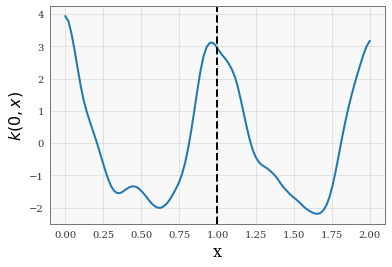

In [29]:
with torch.no_grad():
    xr = torch.linspace(0, 2, 100).cuda()
    plt.plot(xr.cpu().numpy(), model.covar_module(torch.tensor([0]).cuda(), xr).evaluate().detach().cpu().squeeze().numpy())
    plt.axvline(1.0, linestyle='--', color='k')
    plt.ylabel('$k(0, x)$', fontsize=16)
    plt.xlabel('x', fontsize=16)

(array([1.000e+00, 1.244e+03, 4.520e+02, 6.900e+01, 8.100e+01, 1.220e+02,
        2.100e+01, 3.900e+01, 6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([7.69715573e-06, 5.64711659e-02, 1.12934635e-01, 1.69398104e-01,
        2.25861572e-01, 2.82325041e-01, 3.38788510e-01, 3.95251979e-01,
        4.51715448e-01, 5.08178916e-01, 5.64642385e-01, 6.21105854e-01,
        6.77569323e-01, 7.34032791e-01, 7.90496260e-01, 8.46959729e-01,
        9.03423198e-01, 9.59886667e-01, 1.01635014e+00, 1.07281360e+00,
        1.12927707e+00]),
 <a list of 20 Patch objects>)

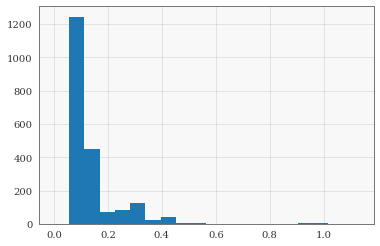

In [28]:
plt.hist(model.covar_module.base_kernel.Z.detach().cpu().numpy(), bins=20)

In [15]:
x0 = torch.tensor([0.]).cuda()
x1 = torch.linspace(0, 10, 500).unsqueeze(-1).cuda()
plt.plot(model.covar_module.forward(x0, x1).squeeze().cpu().detach().numpy())

TypeError: squeeze() missing 1 required positional argument: 'dim'

In [17]:
model.covar_module.lengthscale

tensor([[2.6730]], device='cuda:0', grad_fn=<SoftplusBackward>)

(array([950.,  22.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,  22.]),
 array([-1.44398087, -1.37944732, -1.31491378, -1.25038023, -1.18584668,
        -1.12131314, -1.05677959, -0.99224604, -0.9277125 , -0.86317895,
        -0.7986454 , -0.73411186, -0.66957831, -0.60504476, -0.54051122,
        -0.47597767, -0.41144412, -0.34691058, -0.28237703, -0.21784348,
        -0.15330994, -0.08877639, -0.02424284,  0.0402907 ,  0.10482425,
         0.1693578 ,  0.23389134,  0.29842489,  0.36295844,  0.42749198,
         0.49202553]),
 <a list of 30 Patch objects>)

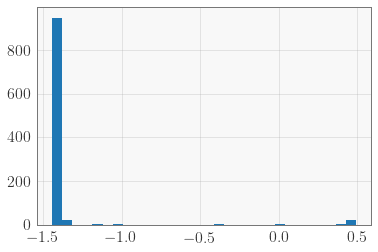

In [65]:
plt.hist(samples[:, 0].cpu().detach().numpy(), bins=30)

(array([340., 127.,   1.,   1.,   0.,   2.,   1.,   1.,   0.,  18.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  32., 442.,
         29.,   0.,   0.,   0.,   0.,   1.,   0.,   4.]),
 array([-0.521559  , -0.4539332 , -0.38630741, -0.31868162, -0.25105583,
        -0.18343004, -0.11580425, -0.04817846,  0.01944733,  0.08707312,
         0.15469891,  0.2223247 ,  0.28995049,  0.35757628,  0.42520208,
         0.49282787,  0.56045366,  0.62807945,  0.69570524,  0.76333103,
         0.83095682,  0.89858261,  0.9662084 ,  1.03383419,  1.10145998,
         1.16908577,  1.23671157,  1.30433736,  1.37196315,  1.43958894,
         1.50721473]),
 <a list of 30 Patch objects>)

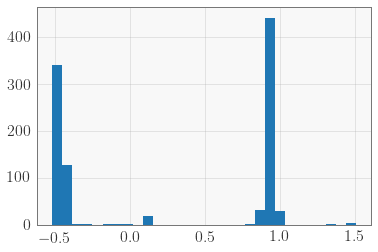

In [66]:
plt.hist(samples[:, 1].cpu().detach().numpy(), bins=30)